In [1]:
from __future__ import unicode_literals
from __future__ import absolute_import, division, print_function
import codecs
import numpy as np
import seaborn as sns
import gensim.models.word2vec as w2v
import multiprocessing
import glob
import pprint
import nltk
import re
import sklearn.manifold
import pandas as pd
import codecs
import matplotlib
%matplotlib notebook

matplotlib.rcParams['font.sans-serif'] = 'FreeSans'
matplotlib.rcParams['font.family'] = "sans-serif"

from matplotlib import pyplot as plt



In [2]:
corpus_raw = u""" """
with codecs.open('testfile.txt','r','utf-8') as filedata:
    corpus_raw += filedata.read()
    
#corpus_raw  = re.sub('\,|\"|\'| \)|\(|\)| \{| \}| \[| \]|!|‘|’|“|”| \:-|\?|।|/|\—', ' ', corpus_raw)
#corpus_test_stop = corpus_raw.split('।')
# remove ka,ko,lai,bata,lay from words
corpus_raw = re.sub(r'ले{1}\s*|को{1}\s*|मा{1}\s|बाट{1}\s*|लाई{1}\s*|का{1}\s*'," ",corpus_raw)
corpus_raw = corpus_raw.replace(','," ")
#remove english letters and numbers
corpus_raw = re.sub(r'([a-z]+)(\n+)|\"*(\n+)|\'*(\n+) | \\*[a-z]*\s+'," ",corpus_raw,flags=re.IGNORECASE )


#PREPARE STOPWORDS
stopwordsNep = u""" """
with codecs.open('stopwordsNepali.txt','r','utf-8') as file:
    stopwordsNep += file.read()

new = re.sub(r'(\n)', " ",stopwordsNep )
new = new.strip(' ')
stopNep = set(new.split(' '))

#tokenize the corpus
corpus_tokenized = re.split(r'\s+',corpus_raw)
filtered_corpus = [w for w in corpus_tokenized if not w in stopNep]

filtered_corpus_sentences_tokens = " ".join(filtered_corpus).split('।')


#very stupid way to create sentenece tokens [  [ " "," "," " ][" "," "," " ]  ]
# this block creates data to be feeded into w2v using stopwords removes corpus

corpusNew = []
for i in filtered_corpus_sentences_tokens:
    if len(i) > 45:
        corpusNew.append(i.strip(' '))

w2vData = []
for i in corpusNew:
    w2vData.append(i.split(' '))
    

In [3]:
import pickle
pickle_out = open("cleanestText.pickle","wb")
pickle.dump(w2vData, pickle_out)
pickle_out.close()

In [4]:
num_features = 150
# Minimum word count threshold.
min_word_count = 8

num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 4

downsampling = 1e-3

seed = 1

news2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

news2vec.build_vocab(w2vData)


news2vec.train(w2vData,total_examples=len(w2vData), epochs=3)

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = news2vec.wv.syn0
#TSNE TRAIN
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[news2vec.wv.vocab[word].index])
            for word in news2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [5]:
points.to_pickle('points.pickle')

In [8]:
news2vec.save('news2vec.w2v')

<IPython.core.display.Javascript object>


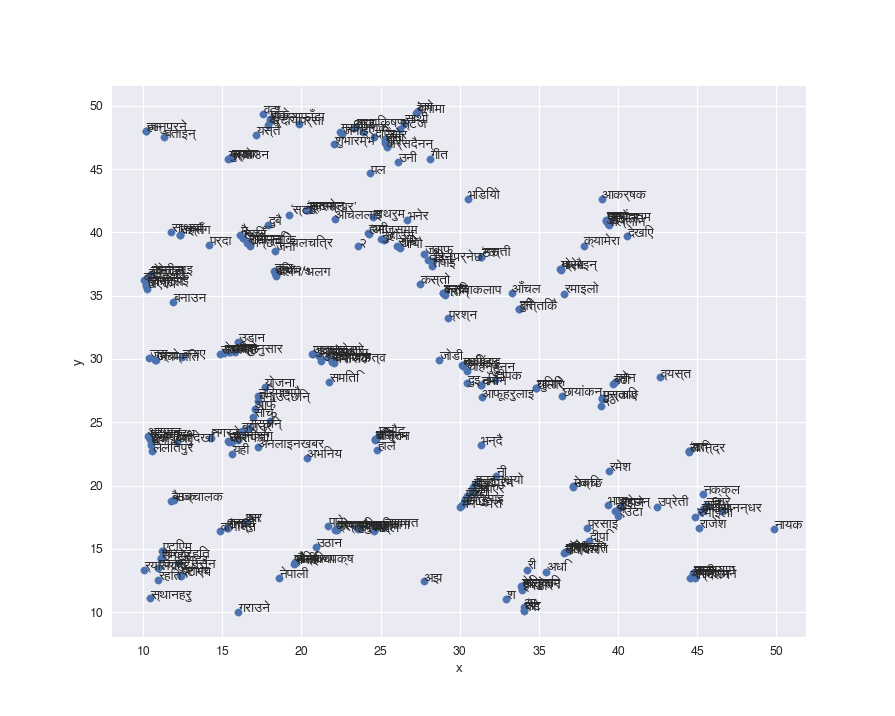

In [31]:
#plot
#dataframe_pickle_in = open('vectordata.pickle','rb')

def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
        ]

    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)


# MAIN CODE TO PLOT REGIONS
plot_region(x_bounds=(10, 50), y_bounds=(10, 50))


In [12]:
news2vec.wv.most_similar('बुधवार')

[('अड्एि', 0.8777250647544861),
 ('नआए', 0.8665957450866699),
 ('विहीवार', 0.8426932692527771),
 ('मंगलवार', 0.8423110842704773),
 ('चाप', 0.8315821290016174),
 ('अंकसम्म', 0.8310667872428894),
 ('अपेक्षा', 0.8267062902450562),
 ('दिशा', 0.8190708160400391),
 ('२२', 0.8175119161605835),
 ('सूचीकरण', 0.8088802695274353)]

In [11]:
points

,word,x,y
0,उच्च,33.085571,35.724060
1,अदालत,32.504353,-33.477531
2,यसअघि,-37.881271,-55.695606
3,हिमालयन,29.768082,62.867256
4,बैंक,6.338477,9.389030
5,नाम,15.656510,-3.144918
6,जारी,20.589468,12.910997
7,गरे,-9.655486,7.974568
8,आदेश,34.358311,-10.637997
9,नहुने,7.137629,24.592894


In [13]:
news2vec.wv.most_similar('हैदराबाद')

[('लकत्ता', 0.9696058034896851),
 ('समेटियो', 0.9605305194854736),
 ('झिनो', 0.9570934176445007),
 ('बराबरीपछि', 0.9529387950897217),
 ('सिल्भा', 0.95243901014328),
 ('उत्रिए', 0.9513879418373108),
 ('मध्यामाञ्चल', 0.9497874975204468),
 ('व्वाइज', 0.9481151700019836),
 ('मध्यपश्चिम', 0.9467564821243286),
 ('मुम्बई', 0.9433586597442627)]

In [14]:
news2vec.wv.most_similar('सिल्भा')

[('विंगर', 0.9647687077522278),
 ('बराबरीपछि', 0.9622243046760559),
 ('स्वरेज', 0.9614486694335938),
 ('५–०', 0.9592810869216919),
 ('मोना', 0.9591885805130005),
 ('मार्सेलो', 0.9587962627410889),
 ('इस्टर्न', 0.9584828615188599),
 ('एमबापे', 0.9570355415344238),
 ('जितपछि', 0.9567926526069641),
 ('व्वाइज', 0.955570638179779)]

In [17]:
news2vec.wv.most_similar('बैंक')

[('संस्था', 0.6585580706596375),
 ('बैंकहरु', 0.6533960103988647),
 ('लिमिटेड', 0.6456997394561768),
 ('राष्ट्र', 0.6260448694229126),
 ('क्यापिटल', 0.6157764792442322),
 ('वित्तीय', 0.5972528457641602),
 ('डेभलपमेन्ट', 0.5946309566497803),
 ('संस्थाहरु', 0.5763183236122131),
 ('सहित', 0.5677585601806641),
 ('फाइनान्स', 0.5570093393325806)]